In [1]:
import os, mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fooof import FOOOF
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.plts.spectra import plot_spectra_shading, plot_spectrum
from fooof.plts.utils import check_ax, check_plot_kwargs

from signal_processing.spectral_analysis import calculate_psd
import basic.arrange_data as arrange

In [2]:
clean_folder = r"Data/Clean/test"
results_foldername = r"Results/test"
exp_folder = r""
exp_condition = r"EC_test"
freq_range = [1,30]
# note: probably have to re-preprocess the data with higher high-cutoff frequency than the used freq in here
# to avoid that part of the higher frequency spectra gets cut off which affects model fitting

brain_regions = {'Frontal':['Fp1','Fp2','AF3','AF4','F3','F4','F7','F8','Fz',
                            'FC5','FC6','FC1','FC2'],
                 'Parietal':['C3','C4','Cz','CP5','CP6','CP1','CP2','P3','P4',
                            'Pz','PO3','PO4']}
# before fooof estimation, for a region, average channels' power together and apply fooof on that

In [32]:
def find_ind_band(spectrum, freqs, freq_interest=[7, 14], bw_size=6):
    # Get indexes of band of interest
    freq_interest_idx = np.where(np.logical_and(freqs>=freq_interest[0],
                        freqs<=freq_interest[1]))
    
    # Find maximum amplitude (peak width) in that bandwidth
    pw = np.max(spectrum[freq_interest_idx])

    # Find center frequency index and value where the peak is
    cf_idx = np.where(spectrum == pw)
    cf = float(freqs[cf_idx])
    
    # Get bandwidth range for the band
    bw = [cf-bw_size/2, cf+bw_size/2]

    # Find individual bandpower indexes based on the binsize
    bp_idx = np.logical_and(freqs>=bw[0], freqs<=bw[1])

    # Average the PSD values in these indexes together to get bandpower
    abs_bp = spectrum[bp_idx].mean()

    # Calculate relative bandpower
    rel_bp = abs_bp / spectrum.mean()

    return cf, pw, bw, abs_bp, rel_bp

Files in Data/Clean/test/ read in: 2
Window type: hamming
Window size: 2048
Overlap: 1024
Zero-padding: 122880

Samples per segment: 2048
Samples for FFT: 124928
Frequency resolution: 0.00819672131147553 Hz


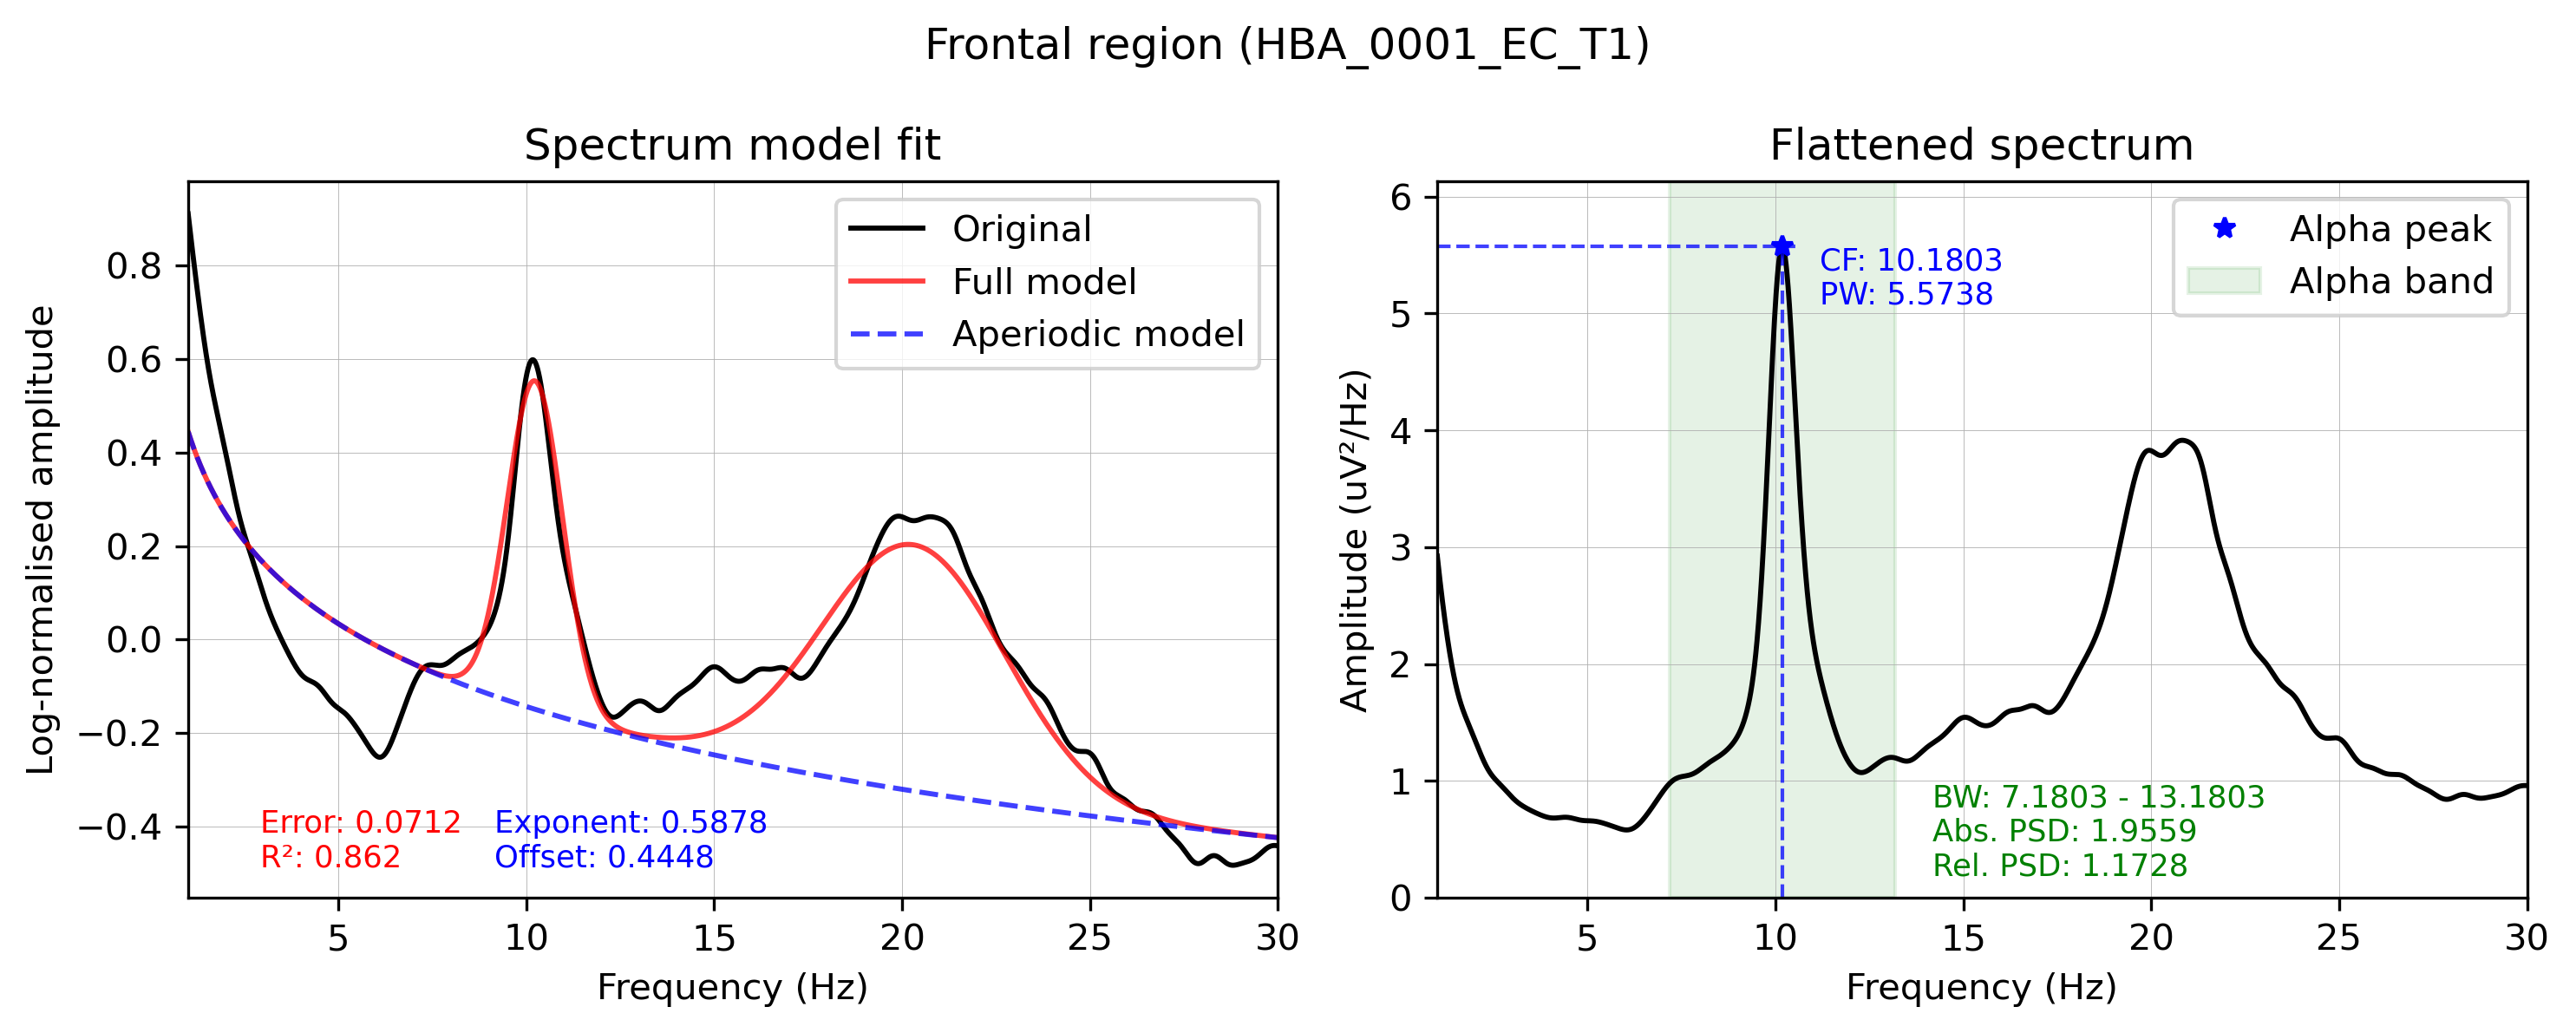

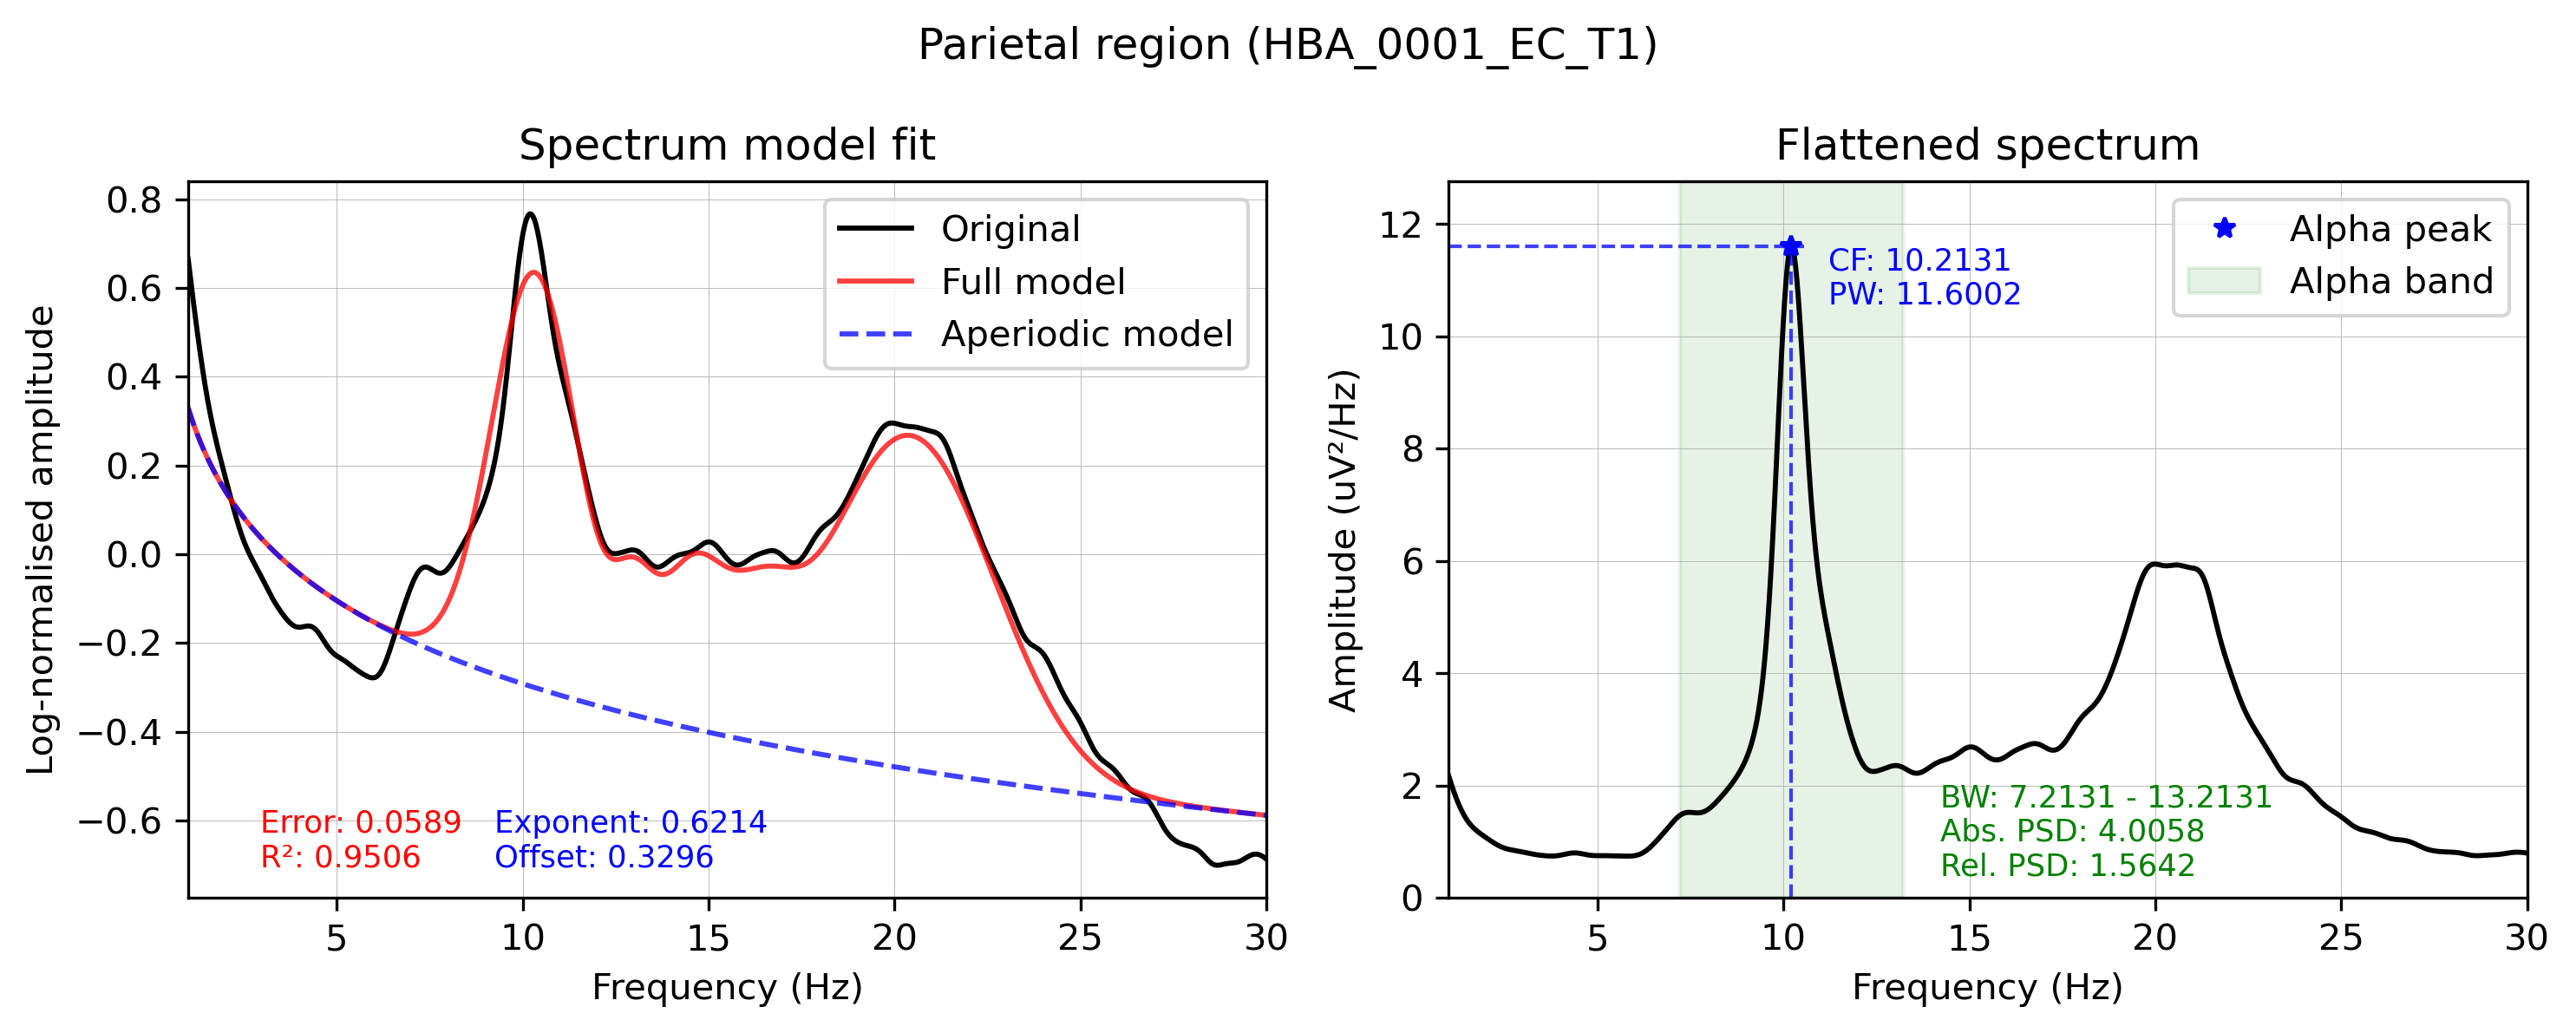

Window type: hamming
Window size: 2048
Overlap: 1024
Zero-padding: 122880

Samples per segment: 2048
Samples for FFT: 124928
Frequency resolution: 0.00819672131147553 Hz


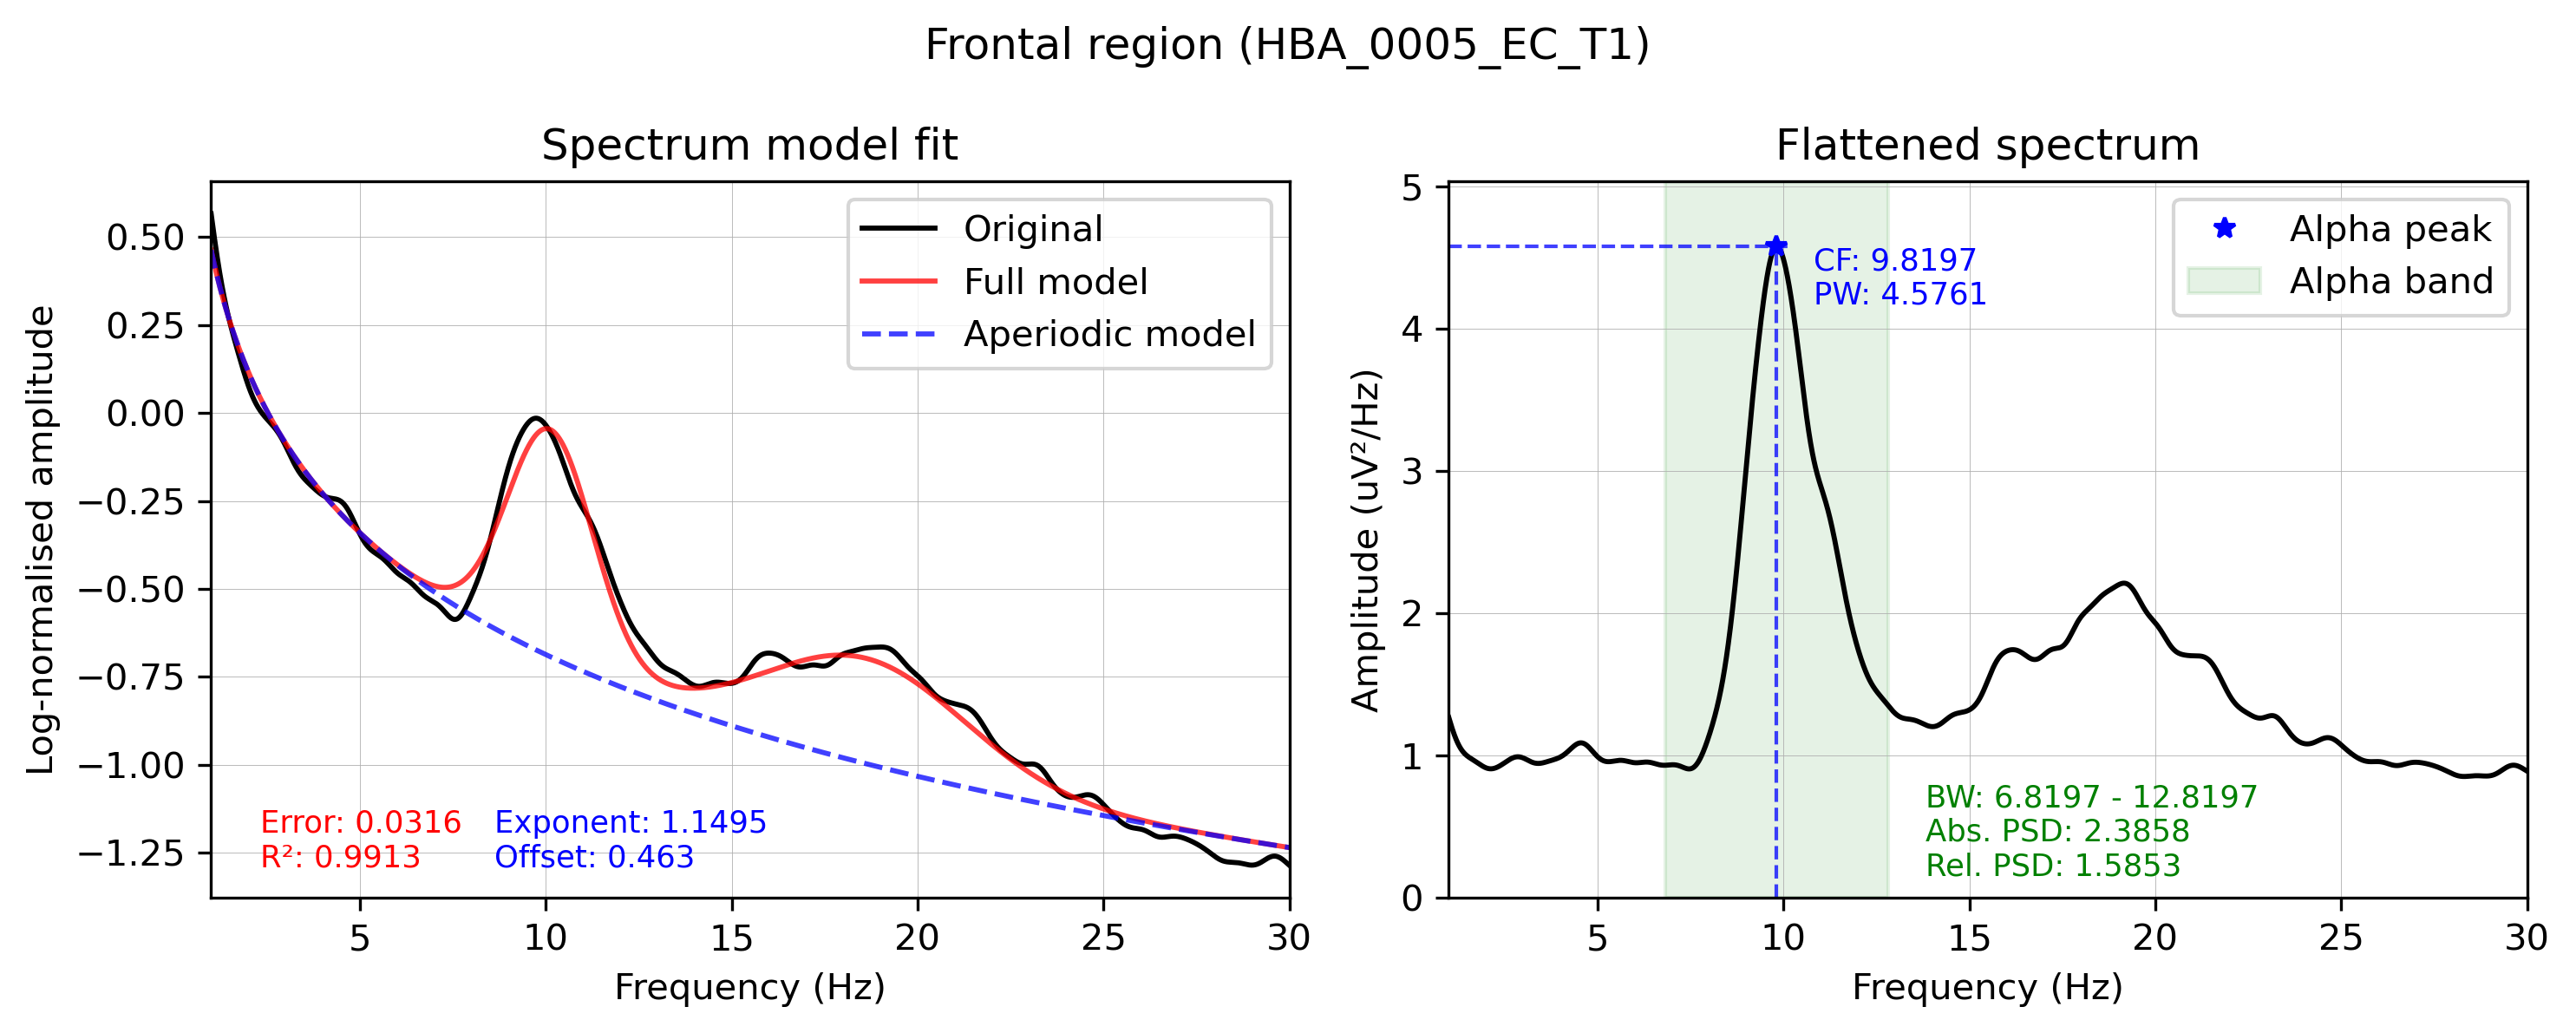

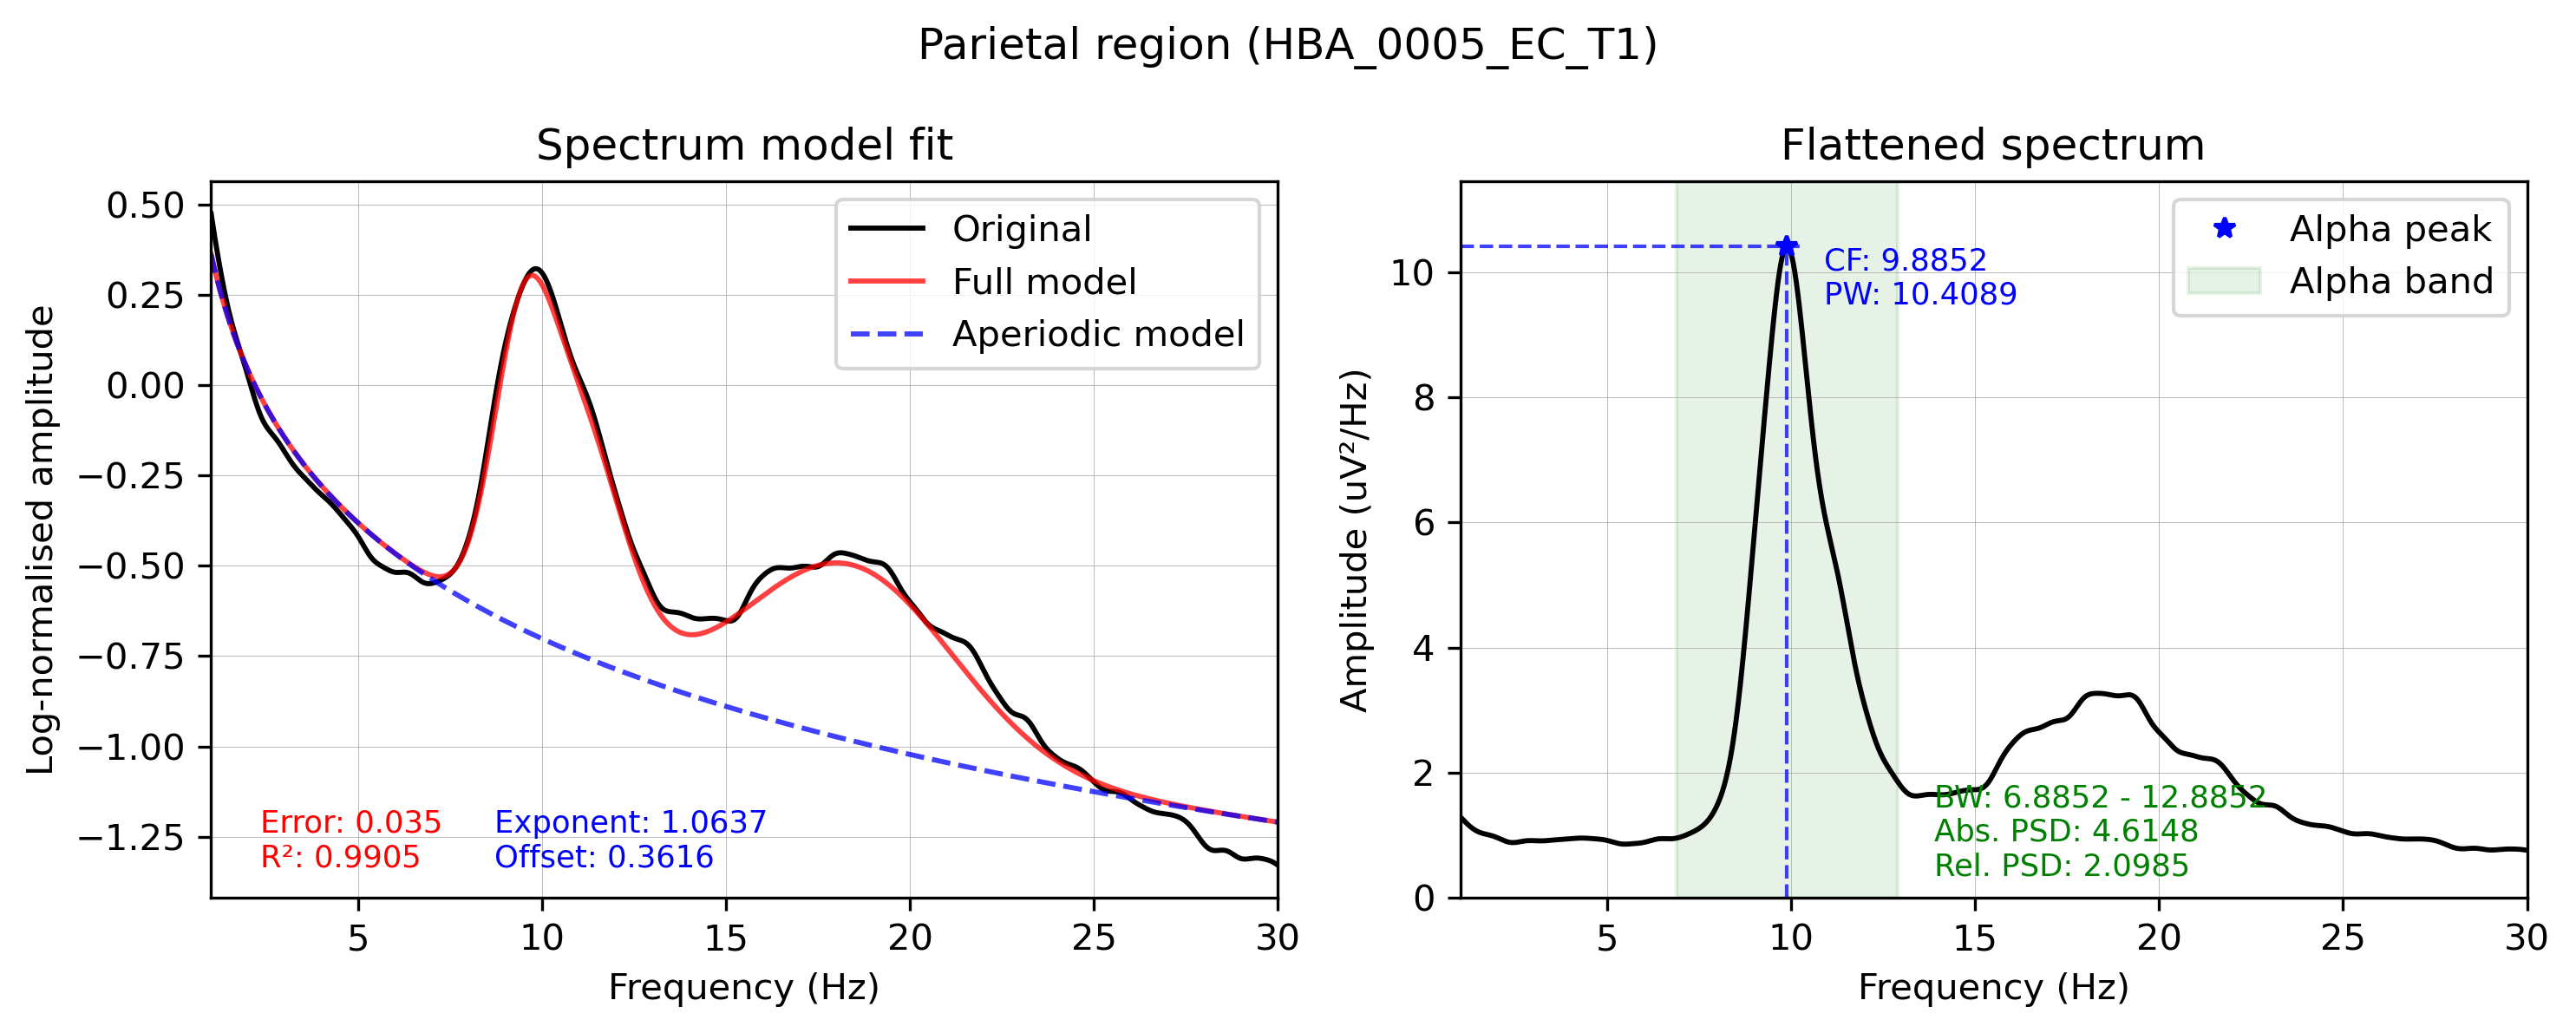

,Exponent,Offset,Alpha CF,Alpha PW,Alpha BW,Alpha absolute power,Alpha relative power,R_2,Error
HBA_0001_EC_T1,0.587834,0.444756,10.180328,5.573756,"[7.18032786885246, 13.18032786885246]",1.955883,1.172834,0.861954,0.071233
HBA_0005_EC_T1,1.149457,0.463036,9.819672,4.576074,"[6.8196721311475414, 12.819672131147541]",2.385805,1.585279,0.991308,0.031618


,Exponent,Offset,Alpha CF,Alpha PW,Alpha BW,Alpha absolute power,Alpha relative power,R_2,Error
HBA_0001_EC_T1,0.621364,0.329648,10.213115,11.600249,"[7.213114754098362, 13.213114754098362]",4.005817,1.564220,0.950595,0.058945
HBA_0005_EC_T1,1.063672,0.361638,9.885246,10.408942,"[6.885245901639344, 12.885245901639344]",4.614826,2.098473,0.990450,0.034966


In [177]:
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,"_clean-epo.fif")

# Define frequency band of interest
bands = {'Alpha' : [7, 14]}

# Set the amplitude scale either to be linear or logarithmic + other predefinables
flat_spectr_scale = 'linear'
plot_rich = True
savefig = True

# shape: [region][subject]
deltas = [[None]*len(file_dirs)]*len(brain_regions.keys())
thetas = [[None]*len(file_dirs)]*len(brain_regions.keys())
alphas = [[None]*len(file_dirs)]*len(brain_regions.keys())
betas = [[None]*len(file_dirs)]*len(brain_regions.keys())
aps = [[None]*len(file_dirs)]*len(brain_regions.keys())

# Pre-create results folders for spectral analysis data
arrange.create_results_folders(exp_folder='',results_foldername=results_foldername)

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)

    # Calculate Welch's power spectrum density (FFT) -> (epochs, channels, freq bins) shape
    [psds,freqs] = calculate_psd(epochs,subject_names[i],fminmax=freq_range,window='hamming',
                                 window_duration=2,window_overlap=0.5,zero_padding=60,verbose=True,plot=False)
    
    # Average all epochs and channels together -> (freq bins,) shape
    if i == 0:
        psds_allch = np.zeros(shape=(len(file_dirs), len(freqs)))
    psds_allch[i] = psds.mean(axis=(0,1))

    # Average all epochs together for each channel and also for each region
    psds = psds.mean(axis=(0))
    df_psds_ch = arrange.array_to_df(subject_names[i],epochs,psds).reset_index().drop(columns='Subject')
    df_psds_regions = arrange.df_channels_to_regions(df_psds_ch,brain_regions).reset_index().drop(columns='Subject')

    # Loop through all regions of interest
    for region in df_psds_regions.columns:
        if i == 0:
            globals()["df_fooof_"+region] = pd.DataFrame(index=subject_names)
        max_n_peaks = float("inf")
        psds_temp = df_psds_regions[region].to_numpy()

        # Fit the spectrum with FOOOF        
        fm = FOOOF(peak_width_limits=[1,12],max_n_peaks=max_n_peaks,min_peak_height=0.225,
                peak_threshold=2.0,aperiodic_mode='fixed',verbose=True)
        fm.fit(freqs,psds_temp,freq_range)
            
        # Log-linear conversion based on the chosen amplitude scale
        if flat_spectr_scale == 'linear':
            flatten_spectrum = 10 ** fm._spectrum_flat
            flat_spectr_ylabel = 'Amplitude (uV\u00b2/Hz)'
        elif flat_spectr_scale == 'log':
            flatten_spectrum = fm._spectrum_flat
            flat_spectr_ylabel = 'Log-normalised amplitude'

        # Find individual alpha band parameters
        cf, pw, bw, abs_bp, rel_bp = find_ind_band(flatten_spectrum, freqs, bands['Alpha'], bw_size=6)

        # Set plot styles
        data_kwargs = {'color' : 'black', 'linewidth' : 1.4,
                       'label' : 'Original'}
        model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75,
                        'label' : 'Full model'}
        aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                            'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
        flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
        hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}

        # Plot power spectrum model + aperiodic fit
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),dpi=300)
        plot_spectrum(fm.freqs, fm.power_spectrum,
                      ax=axs[0], plot_style=None, **data_kwargs)
        plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                      ax=axs[0], plot_style=None, **model_kwargs)
        plot_spectrum(fm.freqs, fm._ap_fit,
                      ax=axs[0], plot_style=None, **aperiodic_kwargs)
        axs[0].set_xlim(freq_range)
        axs[0].grid(linewidth=0.2)
        axs[0].set_xlabel('Frequency (Hz)')
        axs[0].set_ylabel('Log-normalised amplitude')
        axs[0].set_title('Spectrum model fit')
        axs[0].legend()
        
        # Flattened spectrum plot (i.e., minus aperiodic fit)
        plot_spectrum(fm.freqs, flatten_spectrum,
                      ax=axs[1], plot_style=None, **flat_kwargs)
        axs[1].plot(cf, pw, '*', color='blue', label='{} peak'.format(list(bands.keys())[0]))
        axs[1].set_xlim(freq_range)
        axs[1].set_ylim([0,pw*1.1])
        axs[1].axvline(x=cf, ymin=0, ymax=pw/(pw*1.1), **hvline_kwargs)
        axs[1].axhline(y=pw, xmin=0, xmax=cf/(freq_range[1]+1), **hvline_kwargs)
        axs[1].axvspan(bw[0], bw[1], alpha=0.1, color='green', label='{} band'.format(list(bands.keys())[0]))
        axs[1].grid(linewidth=0.2)
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel(flat_spectr_ylabel)
        axs[1].set_title('Flattened spectrum')
        axs[1].legend()

        # If true, plot all the exported variables on the plots
        if plot_rich == True:
            axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                        '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                        (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
            axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                        '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                        (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
            axs[1].text(cf+1, pw, 'CF: '+str(np.round(cf, 4))+'\nPW: '+str(np.round(pw, 4)),
                        verticalalignment='top', color='blue', fontsize=8.5)
            axs[1].text(bw[1]+1, pw*0.025, 'BW: '+str(np.round(bw[0], 4))+' - '+str(np.round(bw[1], 4))+
                        '\nAbs. PSD: '+str(np.round(abs_bp, 4))+'\nRel. PSD: '+str(np.round(rel_bp, 4)),
                        verticalalignment='bottom', color='green', fontsize=8.5)
        
        plt.suptitle('{} region ({})'.format(region,subject_names[i]))
        plt.tight_layout()
        if savefig == True:
            plt.savefig(fname='{}/FOOOF/{}/{}_{}_{}_fooof.png'.format(results_foldername,exp_folder,exp_condition,subject_names[i],region))
        plt.show()

        # Add model parameters to dataframe
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Exponent'] = fm.get_params('aperiodic_params','exponent')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Offset'] = fm.get_params('aperiodic_params','offset')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} CF'.format(list(bands.keys())[0])] = cf
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} PW'.format(list(bands.keys())[0])] = pw
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} BW'.format(list(bands.keys())[0])] = str(bw)
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} absolute power'.format(list(bands.keys())[0])] = abs_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} relative power'.format(list(bands.keys())[0])] = rel_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'R_2'] = fm.get_params('r_squared')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Error'] = fm.get_params('error')

# Export FOOOF data for all regions
for region in df_psds_regions.columns:
    globals()["df_fooof_"+region].to_excel(r"{}/FOOOF/{}/{}_{}_fooof.xlsx".format(results_foldername,exp_folder,exp_condition,region))
    display(globals()["df_fooof_"+region])

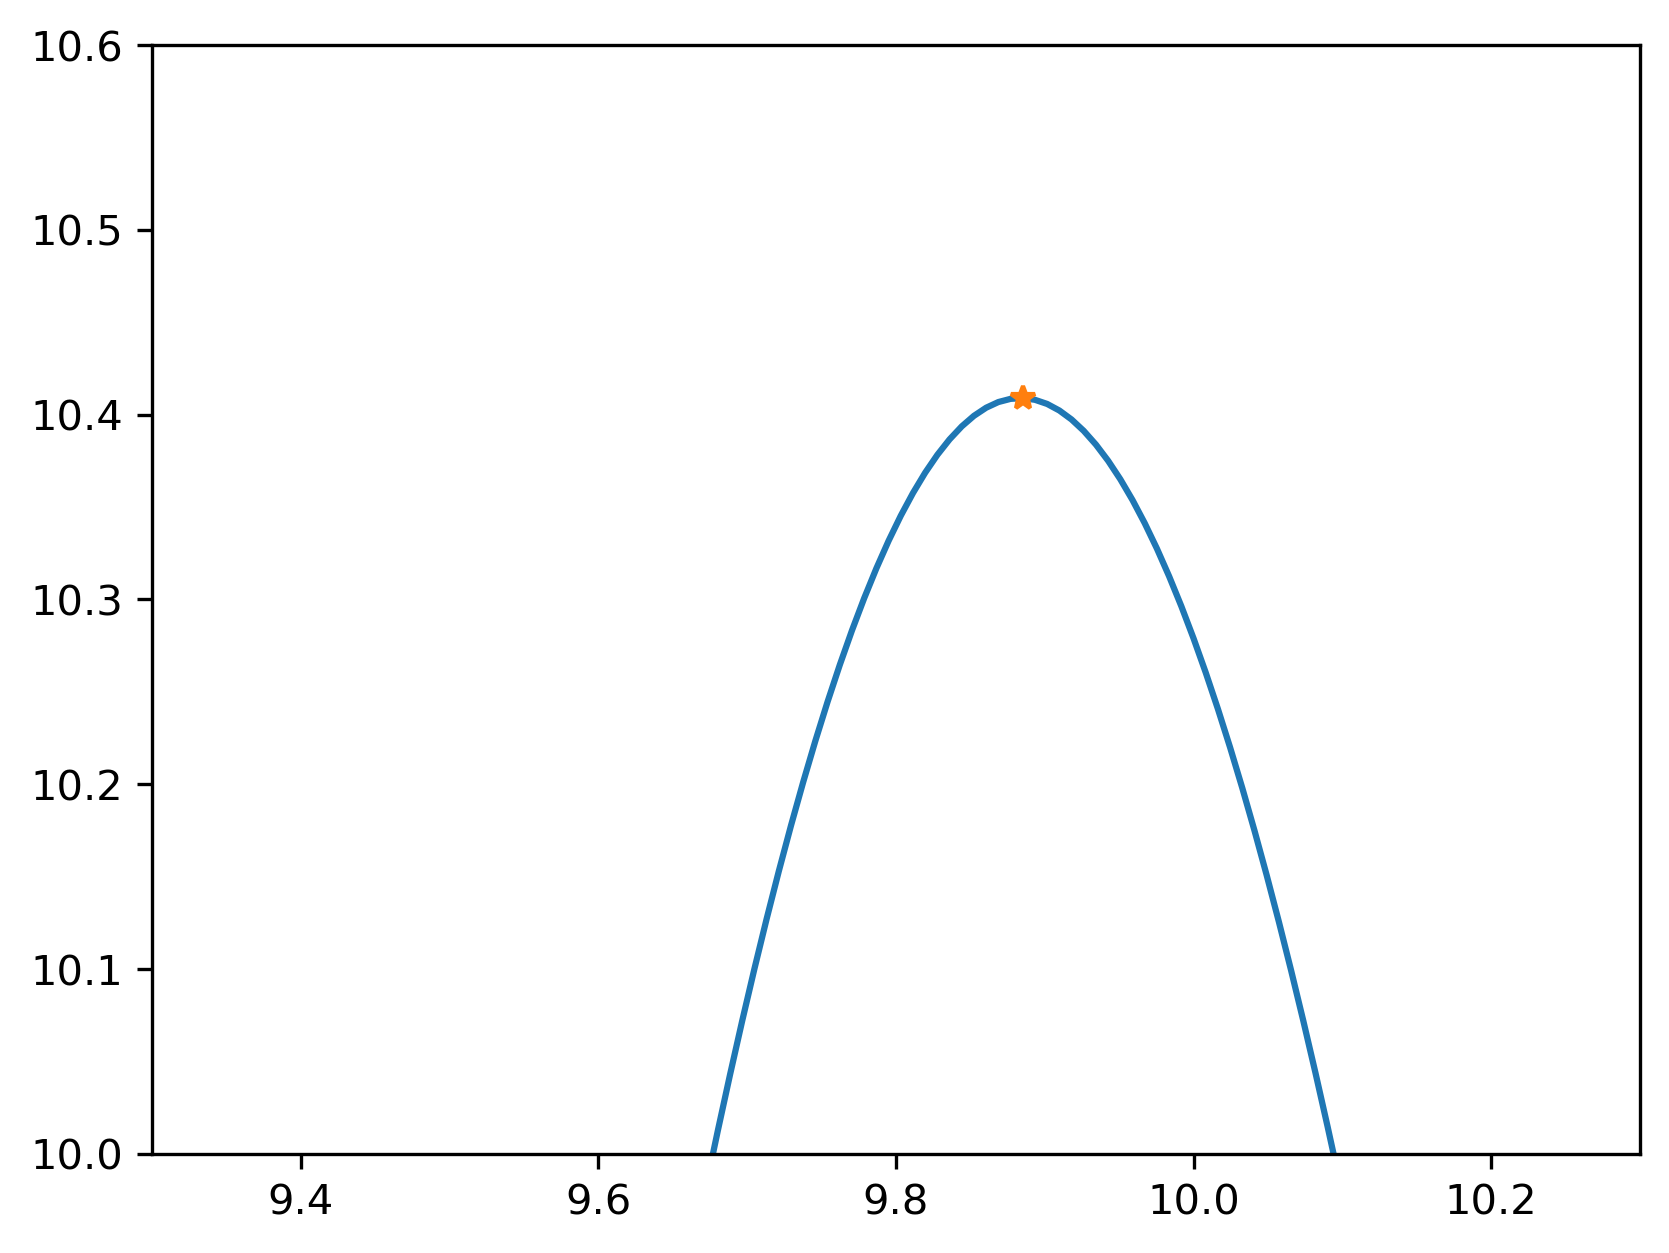

In [182]:
# Testing if number of interpreted points from zero-padding is enough for peak detection

plt.figure(dpi=300)
plt.plot(freqs,flatten_spectrum)
plt.plot(cf,pw,'*')
plt.xlim([9.3,10.3])
plt.ylim([10,10.6])
plt.show()


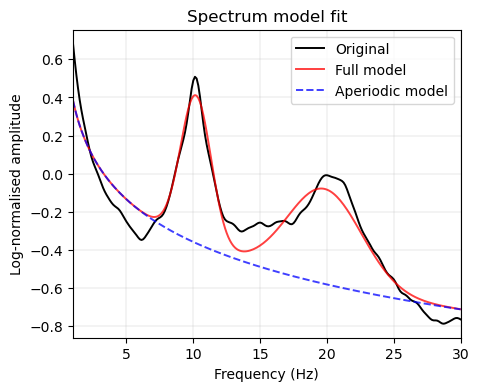

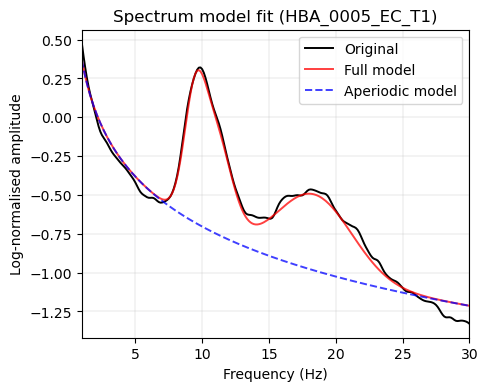

In [80]:
psds_allsubjects = psds_allch.mean(axis=0)

fm.fit(freqs,psds_allsubjects,freq_range)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
plot_spectrum(fm.freqs, fm.power_spectrum,
                      ax=axs, plot_style=None, **data_kwargs)
plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                ax=axs, plot_style=None, **model_kwargs)
plot_spectrum(fm.freqs, fm._ap_fit,
                ax=axs, plot_style=None, **aperiodic_kwargs)
axs.set_xlim(freq_range)
axs.grid(linewidth=0.2)
axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('Log-normalised amplitude')
axs.set_title('Spectrum model fit')
axs.legend()
#plt.savefig(dpi=300,fname='all_participants_fooof.png')

psds_oneparticipants = psds_temp

fm.fit(freqs,psds_oneparticipants,freq_range)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
plot_spectrum(fm.freqs, fm.power_spectrum,
                      ax=axs, plot_style=None, **data_kwargs)
plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                ax=axs, plot_style=None, **model_kwargs)
plot_spectrum(fm.freqs, fm._ap_fit,
                ax=axs, plot_style=None, **aperiodic_kwargs)
axs.set_xlim(freq_range)
axs.grid(linewidth=0.2)
axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('Log-normalised amplitude')
axs.set_title('Spectrum model fit ({})'.format(subject_names[i]))
axs.legend()
#plt.savefig(dpi=300,fname='{}_fooof.png'.format(subject_names[i]))

In [ ]:
# df_exponents = pd.DataFrame({'Frontal': aps[0,:,1],
#                        'Parietal': aps[1,:,1]})

# #from statannotations.Annotator import Annotator

# fig = plt.figure(dpi=100)
# ax = sns.swarmplot(data=df_exponents)
# plt.ylabel('Exponent')
# # annotator = Annotator(ax,pairs=[('Baseline','6 weeks'),('6 weeks','10 weeks'),('Baseline','10 weeks')],
# #                       data=df_aps,plot="swarmplot")\
# #                       .configure(test='t-test_paired')\
# #                       .apply_test().annotate()

# fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 6))
# # Plot the aperiodic parameters for all groups
# plot_aperiodic_params([aps[0],aps[1]],labels=['Frontal','Parietal'],ax=ax[0])
# # Plot the aperiodic fits for all groups
# plot_aperiodic_fits([aps[0],aps[1]],freq_range,control_offset=True,log_freqs=False,labels=['Frontal','Parietal'],ax=ax[1])

# # Compare the peak parameters of theta,alpha,beta peaks between groups
# fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 6))
# plot_peak_params([thetas_00,thetas_06,thetas_07], freq_range=bands.theta, labels=labels,ax=ax[0])
# ax[0].set_title('Theta')
# plot_peak_params([alphas_00,alphas_06,alphas_07], freq_range=bands.alpha, labels=labels,ax=ax[1])
# ax[1].set_title('Alpha')
# plot_peak_params([betas_00,betas_06,betas_07], freq_range=bands.beta, labels=labels,ax=ax[2])
# ax[2].set_title('Beta')

# # Compare the peak fits of theta,alpha,beta peaks between groups
# fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 6))
# plot_peak_fits([thetas_00,thetas_06,thetas_07],labels=labels,ax=ax[0])
# ax[0].set_title('Theta')
# plot_peak_fits([alphas_00,alphas_06,alphas_07],labels=labels,ax=ax[1])
# ax[1].set_title('Alpha')
# plot_peak_fits([betas_00,betas_06,betas_07],labels=labels,ax=ax[2])
# ax[2].set_title('Beta')

**An example of including FOOOF in Methods section**

The FOOOF algorithm (version X.X.X) was used to parameterize neural power spectra. Settings for the algorithm were set as: peak width limits : XX; max number of peaks : XX; minimum peak height : XX; peak threshold : XX; and aperiodic mode : XX. Power spectra were parameterized across the frequency range XX to XX Hz.

*Source: https://fooof-tools.github.io/fooof/reference.html*

In [ ]:
fm.print_settings(description=True)